In [1]:
import os
import torch
import torch.utils.data
import torchvision
from PIL import Image
from pycocotools.coco import COCO
import torchvision.transforms as transforms
import torchvision.ops as ops
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as patches
import json

In [92]:
class myOwnDataset(torch.utils.data.Dataset):
    def __init__(self, root, annotation, transforms=None):
        self.root = root
        self.transforms = transforms
        self.coco = COCO(annotation)
        self.ids = self._get_valid_image_ids()
        
    def _get_valid_image_ids(self):
        # Get image IDs with valid annotations
        valid_ids = []
        for img_id in self.coco.imgs.keys():
            ann_ids = self.coco.getAnnIds(imgIds=img_id)
            if len(ann_ids) > 0:
                valid_ids.append(img_id)
        return valid_ids

    def __getitem__(self, index):
        # Own coco file
        coco = self.coco
        # Image ID
        img_id = self.ids[index]
        # List: get annotation id from coco
        ann_ids = coco.getAnnIds(imgIds=img_id)
        # Dictionary: target coco_annotation file for an image
        coco_annotation = coco.loadAnns(ann_ids)
        # path for input image
        path = coco.loadImgs(img_id)[0]['file_name']
        # open the input image
        img = Image.open(os.path.join(self.root, path)).convert('RGB')
        
        if len(coco_annotation) == 0:
            # Skip images with no annotations
            return self.__getitem__((index + 1) % len(self.ids))

        # number of objects in the image
        num_objs = len(coco_annotation)

        # Bounding boxes for objects
        # In coco format, bbox = [xmin, ymin, width, height]
        # In pytorch, the input should be [xmin, ymin, xmax, ymax]
        with open('./solo/sequence.0/step{step_id}.frame_data.json'.format(step_id = img_id)) as f:
            solo_file = json.load(f)
            is_visible = []
            for i in range(num_objs):
                if solo_file['metrics'][0]['values'][i]['percentVisible'] < 0.7:
                    is_visible.append(False)
                else:
                    is_visible.append(True)
        
        if not any(is_visible):
            return self.__getitem__((index + 1) % len(self.ids))
        boxes = []
        for i in range(num_objs):
            if is_visible[i]:
                xmin = coco_annotation[i]['bbox'][0]
                ymin = coco_annotation[i]['bbox'][1]
                xmax = xmin + coco_annotation[i]['bbox'][2]
                ymax = ymin + coco_annotation[i]['bbox'][3]
                boxes.append([xmin, ymin, xmax, ymax])
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        
        labels = []
        # Some objects are almost invisible in images, so we need to remove them from labels
        for i in range(num_objs):
            if is_visible[i]:
                label = coco_annotation[i]['category_id']
                labels.append(label)
        labels = torch.tensor(labels, dtype=torch.int64)
        # Tensorise img_id
        img_id = torch.tensor([img_id])
        # Size of bbox (Rectangular)
        areas = []
        for i in range(num_objs):
            if is_visible[i]:
                areas.append(coco_annotation[i]['area'])
        areas = torch.as_tensor(areas, dtype=torch.float32)

        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        # Annotation is in dictionary format
        my_annotation = {}
        my_annotation["boxes"] = boxes
        my_annotation["labels"] = labels
        my_annotation["image_id"] = img_id
        my_annotation["area"] = areas
        my_annotation["iscrowd"] = iscrowd

        if self.transforms is not None:
            img = self.transforms(img)

        return img, my_annotation

    def __len__(self):
        return len(self.ids)

In [148]:
def get_transform():
    custom_transforms = []
    custom_transforms.append(torchvision.transforms.ColorJitter(saturation=10))
    custom_transforms.append(torchvision.transforms.ToTensor())
    #custom_transforms.append(transforms.Normalize([0.112, 0.112, 0.113], [0.112, 0.112, 0.112]))
    return torchvision.transforms.Compose(custom_transforms)

In [149]:
def image_shower(images, labels, n=1):
    for i, image in enumerate(images[:n]):
        fig, ax = plt.subplots(1)
        plt.subplot(n, n, i + 1)
        image = image/ 2 + 0.5
        ax.imshow(image.numpy().transpose((1, 2, 0)).squeeze())
        print(labels[0]['image_id'])
    for box in labels[0]["boxes"]:
        # Extract coordinates
        x_min, y_min, x_max, y_max = box
        print(box)
    
        # Calculate width and height
        width = x_max - x_min
        height = y_max - y_min
    
        # Create rectangle patch
        rect = patches.Rectangle((x_min, y_min), width, height, linewidth=1, edgecolor='r', facecolor='none')
    
        # Add rectangle patch to axes
        ax.add_patch(rect)
    ax.set_aspect('equal')
    plt.show()
    print("Real Labels: ", ' '.join('%5s' % classes[label.item()] for label in labels[0]["labels"]))

In [150]:
train_data_dir = './coco/images'
train_coco = './coco/bbox.json'

# create own Dataset
my_dataset = myOwnDataset(root=train_data_dir,
                          annotation=train_coco,
                          transforms=get_transform()
                          )

# collate_fn needs for batch
def collate_fn(batch):
    return tuple(zip(*batch))

# Batch size
train_batch_size = 10

# own DataLoader
data_loader = torch.utils.data.DataLoader(my_dataset,
                                          batch_size=train_batch_size,
                                          shuffle=True,
                                          num_workers=0,
                                          collate_fn=collate_fn)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


tensor([1])
tensor([ 53.,   0., 326., 166.])


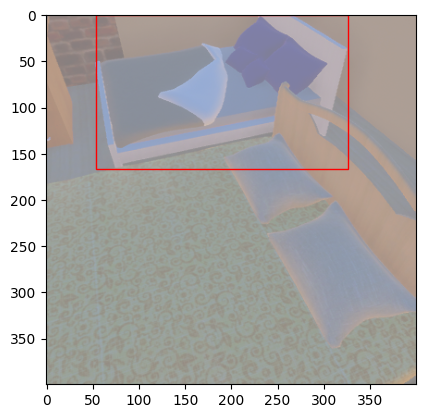

Real Labels:    bed


In [171]:
classes = {1:'bed', 2: 'Lamp', 3:'Bedside Table', 4:'Closet', 5:'Sofa', 6:"Table", 7:"Chair"}
images, labels = next(iter(data_loader))
image_shower(images, labels)

In [10]:
torch.cuda.empty_cache()

In [11]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model
    

# There are 7 types of furniture + background
num_classes = 8
num_epochs = 10
model = get_model_instance_segmentation(num_classes)

# move model to the right device
model.to(device)
    
# parameters
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

len_dataloader = len(data_loader)

for epoch in range(num_epochs):
    model.train()
    i = 0    
    for imgs, annotations in data_loader:
        
        i += 1
        imgs = list(img.to(device) for img in imgs)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
        
    
        loss_dict = model(imgs, annotations)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        print(f'Iteration: {i}/{len_dataloader}, Loss: {losses}')

C:\Users\getto\miniconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\getto\miniconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to C:\Users\getto/.cache\torch\hub\checkpoints\fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|███████████████████████████████████████████████████████████████████████████████| 160M/160M [00:14<00:00, 11.5MB/s]


Iteration: 1/110, Loss: 2.309415102005005
Iteration: 2/110, Loss: 0.9855639934539795
Iteration: 3/110, Loss: 0.7185849547386169
Iteration: 4/110, Loss: 0.6613002419471741
Iteration: 5/110, Loss: 0.7474369406700134
Iteration: 6/110, Loss: 0.9683349132537842
Iteration: 7/110, Loss: 0.5052668452262878
Iteration: 8/110, Loss: 0.8445440530776978
Iteration: 9/110, Loss: 0.607060432434082
Iteration: 10/110, Loss: 0.6666728258132935
Iteration: 11/110, Loss: 0.5204097032546997
Iteration: 12/110, Loss: 0.806964635848999
Iteration: 13/110, Loss: 0.6145076751708984
Iteration: 14/110, Loss: 0.5690931677818298
Iteration: 15/110, Loss: 0.5409024357795715
Iteration: 16/110, Loss: 0.6237685680389404
Iteration: 17/110, Loss: 0.5521203875541687
Iteration: 18/110, Loss: 0.50510573387146
Iteration: 19/110, Loss: 0.4217243194580078
Iteration: 20/110, Loss: 0.361991822719574
Iteration: 21/110, Loss: 0.484177827835083
Iteration: 22/110, Loss: 0.36038556694984436
Iteration: 23/110, Loss: 0.5046589374542236
Ite

Iteration: 76/110, Loss: 0.17346128821372986
Iteration: 77/110, Loss: 0.08204760402441025
Iteration: 78/110, Loss: 0.12592226266860962
Iteration: 79/110, Loss: 0.12511496245861053
Iteration: 80/110, Loss: 0.12591980397701263
Iteration: 81/110, Loss: 0.0879303365945816
Iteration: 82/110, Loss: 0.11154584586620331
Iteration: 83/110, Loss: 0.08120322972536087
Iteration: 84/110, Loss: 0.165449321269989
Iteration: 85/110, Loss: 0.11855901777744293
Iteration: 86/110, Loss: 0.11592362076044083
Iteration: 87/110, Loss: 0.13928502798080444
Iteration: 88/110, Loss: 0.11040540784597397
Iteration: 89/110, Loss: 0.11124037206172943
Iteration: 90/110, Loss: 0.10176241397857666
Iteration: 91/110, Loss: 0.14579200744628906
Iteration: 92/110, Loss: 0.086028553545475
Iteration: 93/110, Loss: 0.09017639607191086
Iteration: 94/110, Loss: 0.08497077226638794
Iteration: 95/110, Loss: 0.06746485084295273
Iteration: 96/110, Loss: 0.08243070542812347
Iteration: 97/110, Loss: 0.10639654844999313
Iteration: 98/1

Iteration: 39/110, Loss: 0.08694678544998169
Iteration: 40/110, Loss: 0.07431857287883759
Iteration: 41/110, Loss: 0.060806628316640854
Iteration: 42/110, Loss: 0.0791219025850296
Iteration: 43/110, Loss: 0.059451282024383545
Iteration: 44/110, Loss: 0.10848797112703323
Iteration: 45/110, Loss: 0.05168014392256737
Iteration: 46/110, Loss: 0.04872039332985878
Iteration: 47/110, Loss: 0.08850913494825363
Iteration: 48/110, Loss: 0.06232035532593727
Iteration: 49/110, Loss: 0.06965736299753189
Iteration: 50/110, Loss: 0.09686295688152313
Iteration: 51/110, Loss: 0.10573936253786087
Iteration: 52/110, Loss: 0.049484994262456894
Iteration: 53/110, Loss: 0.12854599952697754
Iteration: 54/110, Loss: 0.05643023923039436
Iteration: 55/110, Loss: 0.062291767448186874
Iteration: 56/110, Loss: 0.046882323920726776
Iteration: 57/110, Loss: 0.06680288165807724
Iteration: 58/110, Loss: 0.03921744227409363
Iteration: 59/110, Loss: 0.050879158079624176
Iteration: 60/110, Loss: 0.055380694568157196
Iter

Iteration: 1/110, Loss: 0.046866320073604584
Iteration: 2/110, Loss: 0.07518795877695084
Iteration: 3/110, Loss: 0.05570609122514725
Iteration: 4/110, Loss: 0.04702136293053627
Iteration: 5/110, Loss: 0.06940853595733643
Iteration: 6/110, Loss: 0.07831690460443497
Iteration: 7/110, Loss: 0.0352812260389328
Iteration: 8/110, Loss: 0.057467199862003326
Iteration: 9/110, Loss: 0.05049224942922592
Iteration: 10/110, Loss: 0.05053813010454178
Iteration: 11/110, Loss: 0.07267173379659653
Iteration: 12/110, Loss: 0.04344654828310013
Iteration: 13/110, Loss: 0.03615820035338402
Iteration: 14/110, Loss: 0.0443020798265934
Iteration: 15/110, Loss: 0.036887623369693756
Iteration: 16/110, Loss: 0.09217604994773865
Iteration: 17/110, Loss: 0.04919659346342087
Iteration: 18/110, Loss: 0.028587520122528076
Iteration: 19/110, Loss: 0.037392258644104004
Iteration: 20/110, Loss: 0.05281500518321991
Iteration: 21/110, Loss: 0.05558047816157341
Iteration: 22/110, Loss: 0.08705325424671173
Iteration: 23/11

Iteration: 73/110, Loss: 0.05093061923980713
Iteration: 74/110, Loss: 0.038986898958683014
Iteration: 75/110, Loss: 0.06425827741622925
Iteration: 76/110, Loss: 0.06066771224141121
Iteration: 77/110, Loss: 0.058526404201984406
Iteration: 78/110, Loss: 0.056643128395080566
Iteration: 79/110, Loss: 0.05225340649485588
Iteration: 80/110, Loss: 0.06466060876846313
Iteration: 81/110, Loss: 0.04832187294960022
Iteration: 82/110, Loss: 0.04146226868033409
Iteration: 83/110, Loss: 0.04420081153512001
Iteration: 84/110, Loss: 0.03574056178331375
Iteration: 85/110, Loss: 0.07770679891109467
Iteration: 86/110, Loss: 0.028767185285687447
Iteration: 87/110, Loss: 0.052028827369213104
Iteration: 88/110, Loss: 0.043035976588726044
Iteration: 89/110, Loss: 0.04756573960185051
Iteration: 90/110, Loss: 0.030919672921299934
Iteration: 91/110, Loss: 0.04301039129495621
Iteration: 92/110, Loss: 0.03938564658164978
Iteration: 93/110, Loss: 0.06706134974956512
Iteration: 94/110, Loss: 0.06579050421714783
Ite

Iteration: 34/110, Loss: 0.04173674434423447
Iteration: 35/110, Loss: 0.03826245293021202
Iteration: 36/110, Loss: 0.024610955268144608
Iteration: 37/110, Loss: 0.03617105260491371
Iteration: 38/110, Loss: 0.03858685865998268
Iteration: 39/110, Loss: 0.02709091827273369
Iteration: 40/110, Loss: 0.05426447093486786
Iteration: 41/110, Loss: 0.02998633310198784
Iteration: 42/110, Loss: 0.05455763638019562
Iteration: 43/110, Loss: 0.0472976490855217
Iteration: 44/110, Loss: 0.025359490886330605
Iteration: 45/110, Loss: 0.05216832086443901
Iteration: 46/110, Loss: 0.040745608508586884
Iteration: 47/110, Loss: 0.024605708196759224
Iteration: 48/110, Loss: 0.04032456874847412
Iteration: 49/110, Loss: 0.05345018580555916
Iteration: 50/110, Loss: 0.026379508897662163
Iteration: 51/110, Loss: 0.04494704678654671
Iteration: 52/110, Loss: 0.02602769434452057
Iteration: 53/110, Loss: 0.030364174395799637
Iteration: 54/110, Loss: 0.04311029613018036
Iteration: 55/110, Loss: 0.04297767952084541
Itera

Iteration: 105/110, Loss: 0.023287152871489525
Iteration: 106/110, Loss: 0.02815214917063713
Iteration: 107/110, Loss: 0.05060407146811485
Iteration: 108/110, Loss: 0.020352628082036972
Iteration: 109/110, Loss: 0.018793707713484764
Iteration: 110/110, Loss: 0.02252236381173134


In [12]:
model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [13]:
def get_transform_test():
    custom_transforms = []
    custom_transforms.append(torchvision.transforms.Resize((400, 400)))
    custom_transforms.append(torchvision.transforms.ToTensor())
    #custom_transforms.append(transforms.Normalize([0.162, 0.162, 0.163], [0.112, 0.112, 0.112]))
    return torchvision.transforms.Compose(custom_transforms)

In [172]:
random_image_path = "table.png"
img = Image.open(random_image_path).convert("RGB")
transform = get_transform_test()
img = transform(img)
img = img.unsqueeze(0)  # Add a batch dimension

In [173]:
img = img.to(device)
with torch.no_grad():
    predictions = model(img)

In [174]:
boxes = predictions[0]["boxes"].cpu().numpy()
labels = predictions[0]["labels"].cpu().numpy()
scores = predictions[0]["scores"].cpu().numpy()

# Apply non-maximum suppression (NMS) to filter the bounding box predictions
keep = ops.nms(torch.from_numpy(boxes), torch.from_numpy(scores), iou_threshold = 0.5)

# Filter the bounding boxes, labels, and scores using the NMS results
boxes = boxes[keep]
labels = labels[keep]
scores = scores[keep]

[ 14.147812 117.304436 397.29272  334.92407 ]


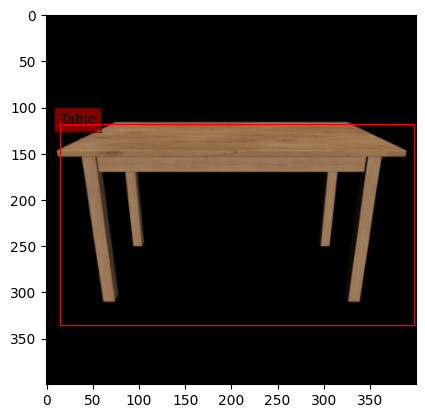

In [175]:

# Convert image tensor to numpy array
image = img.squeeze(0).permute(1, 2, 0).cpu().numpy()

# Create figure and axes
fig, ax = plt.subplots(1)
ax.imshow(image)


if isinstance(labels, np.int64):
    label = labels
    labels = []
    labels.append(label)
    box = boxes
    boxes = []
    boxes.append(box)

# Iterate over bounding boxes and labels
for box, label in zip(boxes, labels):
    # Extract coordinates
    x_min, y_min, x_max, y_max = box
    print(box)
    
    # Calculate width and height
    width = x_max - x_min
    height = y_max - y_min
    
    # Create rectangle patch
    rect = patches.Rectangle((x_min, y_min), width, height, linewidth=1, edgecolor='r', facecolor='none')
    
    # Add rectangle patch to axes
    ax.add_patch(rect)
    
    # Add label text to axes
    ax.text(x_min, y_min, f"{classes[label]}", bbox=dict(facecolor='r', alpha=0.5))

# Set aspect ratio and show plot
ax.set_aspect('equal')
plt.show()

In [48]:
my_dataset.coco.cats

{1: {'id': 1,
  'name': 'bed',
  'supercategory': 'default',
  'keypoints': [],
  'skeleton': []},
 2: {'id': 2,
  'name': 'Lamp',
  'supercategory': 'default',
  'keypoints': [],
  'skeleton': []},
 3: {'id': 3,
  'name': 'Bedside Table',
  'supercategory': 'default',
  'keypoints': [],
  'skeleton': []},
 4: {'id': 4,
  'name': 'Closet',
  'supercategory': 'default',
  'keypoints': [],
  'skeleton': []},
 5: {'id': 5,
  'name': 'Sofa',
  'supercategory': 'default',
  'keypoints': [],
  'skeleton': []},
 6: {'id': 6,
  'name': 'Table',
  'supercategory': 'default',
  'keypoints': [],
  'skeleton': []},
 7: {'id': 7,
  'name': 'Chair',
  'supercategory': 'default',
  'keypoints': [],
  'skeleton': []}}